# Testing ground for the alus.py script

In [279]:
import pandas as pd
import numpy as np
import shutil
import os
import scipy as sp
import matplotlib.pyplot as plt
import re

In [280]:
for_noise = 10
for_outliers = 7

## Gaussian definition

In [281]:
import pandas as pd
import numpy as np
import shutil
import os
import scipy as sp
import matplotlib.pyplot as plt
import re

################################################################
for_outliers = 10
for_noise = 7
################################################################
def gauss(x, mu, sigma, c, y):

    return c * 1 / (sigma * np.sqrt(2*np.pi)) * np.exp(-(x-mu)**2 / (2 * sigma**2)) + y

################################################################

class SpectralLine():

    def __init__(self, data):
        self.line = data
        self.intensity = data['intensity']
        self.energy = data['energy']
        self.length = len(data)

        try:

            self.max_index = data['intensity'].idxmax()
            self.before_max = data.loc[:self.max_index, 'intensity']
            self.after_max = data.loc[self.max_index:, 'intensity']
            self.good_before_max = data.loc[:self.max_index,'intensity'].is_monotonic_increasing
            self.good_after_max = data.loc[self.max_index:, 'intensity'].is_monotonic_decreasing

        except ValueError:
            print("substituting the rest with nans!")
            self.max_index = np.nan
            self.before_max = np.nan
            self.after_max = np.nan
            self.good_before_max = np.nan
            self.good_after_max = np.nan

    def get_first_point(self):
        first_point_energy = self.energy[0]
        first_point_intensity = self.intensity[0]
        return (first_point_energy, first_point_intensity)
    
    def get_point(self, which_point):
        point_intensity = self.intensity.iloc[which_point]
        point_energy = self.energy.iloc[which_point]
        return (point_energy, point_intensity)
    
################################################################

class Spectrum():

    def __init__(self, spectrum_path, progressions_path):
        self.spectrum_path = spectrum_path
        self.progressions_path = progressions_path
        self.mean_intensity = self.get_continuum().mean()
        # self.dirty_progressions = self.get_progression_intensities()

    def create_spectrum(self):
        """
        Creates pandas dataframe
        from .dpt file
        """
        spectrum_variables = ['energy', 'intensity']
        spectrum = pd.read_csv(f'{self.spectrum_path}', header=None, names=spectrum_variables, dtype={'energy': 'float64', 'intensity': 'float64'})
        return spectrum

    def get_energy(self):
        """
        gets the energy column (x/0)
        from the spectrum
        """
        spectrum = self.create_spectrum()
        return spectrum['energy']
    
    def get_intensity(self):
        """
        get intensity column (y/1)
        from the spectrum df
        """
        spectrum = self.create_spectrum()
        return spectrum['intensity']

    def get_continuum(self, window=301, polynomial_order=2):
        """
        applies scipy Savitzky-Golay filter
        funtion to get the continuum background
        of the spectrum
        """
        background = sp.signal.savgol_filter(self.get_intensity(), window_length=window, polyorder=polynomial_order)
        return background
    
    def subtract_continuum(self):
        """
        subtracts continuum with
        self.get_continuum and returns
        the resulting spectrum
        """
        x = self.get_energy()
        y = self.get_intensity() - self.get_continuum()
        df = pd.DataFrame({
            'energy': x,
            'intensity': y
        })
        return df
    
    def find_progressions(self):
        """
        finds progressions
        from raw/progressions
        folder and saves them
        in pandas dataframes
        """
        progressions = {}
        for file in os.listdir(self.progressions_path):
            progressions[f'{file}'] = None
            df = pd.read_csv(f'{self.progressions_path}{file}', skiprows=4, names=['index', 'v', 'j_prime', 'v_pprime', 'j_pprime', 'position'], sep='\s+', usecols=['v_pprime', 'j_pprime', 'position'])
            progressions[f'{file}'] = df
        
        return progressions

    def get_positions(self):
        """
        from progressions' information
        (energy, intensity) saves only x-axis position
        information (energy)
        """

        positions = {}
        for name, progression in self.find_progressions().items():
            positions[name] = progression['position']
    
        return positions
    
    def get_v_pprimes(self):
        """
        from progressions' information
        (energy, intensity) saves only v'' info
        """
        
        v_pprimes = {}
        for name, progression in self.find_progressions().items():
            v_pprimes[name] = progression['v_pprime']
    
        return v_pprimes
    
    def get_j_pprimes(self):
        """
        from progressions' information
        (energy, intensity) saves only j'' info
        """
        
        j_pprimes = {}
        for name, progression in self.find_progressions().items():
            j_pprimes[name] = progression['j_pprime']
    
        return j_pprimes
    
    def find_nearest_intensity(self, value):
        """
        finds the nearest experimental spectrum
        point to each of the calculated progressions' position
        """
        s = self.create_spectrum()
        energy = s['energy']
        intensity = s['intensity']
        idx = (np.abs(energy - value)).argmin(skipna=True)
        points_around = 4

        try:

            for shift in range(points_around + 1):
                possible_intensities = intensity[idx-points_around+shift:idx+points_around+1+shift]

                print(f"Checking for max in\n{possible_intensities}")
                max_from_possible = possible_intensities.max()
                not_good = max_from_possible == possible_intensities.iloc[0] or max_from_possible == possible_intensities.iloc[-1]

                if not not_good:
                    break

            idx_max = possible_intensities[possible_intensities == max_from_possible].index[0]
            max_row = s.iloc[idx_max]
            return max_row
        
        except IndexError:

            print("Index out of spectrum, returning nans!")
            return pd.Series({'energy': np.nan, 'intensity': np.nan})
    
    def get_progression_intensities(self):
        """
        by exploiting self.find_nearest_intensity()
        finds all experimental positions
        of calculated progression positions.
        iterates through all progressions in 
        raw/progressions directory.
        if progression is not in the range of spectrum,
        those values are skipped with try/except block.
        """
        progressions = self.get_positions()
        progression_idxs = range(len(progressions.keys())) 
        position_idxs = [range(len(list(progressions.values())[progression_idx])) for progression_idx in progression_idxs]
        found_lines = [[] for i in progression_idxs]
        for progression_idx in progression_idxs:
            print(f'taking progression {progression_idx}...')
            for position_idx in position_idxs[progression_idx]:
                try:
                    print(f'taking position {position_idx} in progression {progression_idx}')
                    found_line = self.find_nearest_intensity(list(progressions.values())[progression_idx][position_idx])
                    print(f'found line is {list(progressions.values())[progression_idx][position_idx]}')
                    print(f"found line literally is:\n{found_line}\n")
                    found_lines[progression_idx].append(found_line.to_frame().T)
                except IndexError:
                    print('progression out of spectrum, skipping to next iteration')
                    found_lines[progression_idx].append(pd.DataFrame({'energy': np.nan, 'intensity': np.nan}))

        final_format = {key: value for key, value in progressions.items()}
        for progression_idx in range(len(list(progressions.keys()))):
            pandas_progression = pd.concat(found_lines[progression_idx])
            final_format[list(progressions.keys())[progression_idx]] = pandas_progression
        return final_format
    
    def find_good_lines(self, found_lines):
        """
        from found progressions,
        extracts only the lines which could undergo
        gaussian approximation.
        takes few points around determined maximum value and
        fits those to gaussian function. Then returns position
        for each good line, according to gaussian fit.
        """
        found_lines_keys = list(found_lines.keys())
        points_around = 4
        energy = self.get_energy()
        continuum = pd.DataFrame({
            'energy': energy,
            'intensity': self.get_continuum()
        })
        spectrum = self.create_spectrum()
        progressions = list(found_lines.values())
        progression_idxs = range(len(progressions))
        position_idxs = [range(len(progressions[progression_idx])) for progression_idx in progression_idxs]
        clean_lines = {key: [] for key, _ in found_lines.items()}

        for progression_idx in progression_idxs:

            print(f'taking progression {progression_idx}')

            for position_idx in position_idxs[progression_idx]:

                if position_idx == 0:
                    previous_point_name = progressions[progression_idx].iloc[position_idx+2].name
                else:
                    previous_point_name = progressions[progression_idx].iloc[position_idx-1].name

                full_point = progressions[progression_idx].iloc[position_idx]
                point_name = progressions[progression_idx].iloc[position_idx].name

                if position_idx == len(position_idxs[progression_idx])-1:
                    next_point_name = progressions[progression_idx].iloc[position_idx-2].name
                else:
                    next_point_name = progressions[progression_idx].iloc[position_idx+1].name

                print(f'got point {point_name} with energy {full_point}')
                continuum_around_point = continuum.iloc[point_name-30:point_name+30]['intensity'].mean()
                print(f"continuum level around point:\n{continuum_around_point}\n")
                possible_line = spectrum.iloc[point_name-points_around:point_name+points_around+1]
                possible_line_previous = spectrum.iloc[previous_point_name-points_around:previous_point_name+points_around+1]
                possible_line_next = spectrum.iloc[next_point_name-points_around:next_point_name+points_around+1]
                
                print("---------------------- 1st try ---------------------")
                line_to_check = SpectralLine(possible_line)
                line_to_check_previous = SpectralLine(possible_line_previous)
                line_to_check_next = SpectralLine(possible_line_next)
                print(f'possible line is:\n{line_to_check.line}')
                print(f'max intensity is at point:\n{line_to_check.max_index}')
                print(f'part of the line before the max index:\n{line_to_check.before_max}')
                print(f'part of the line after the max index:\n{line_to_check.after_max}')
                print(f"Line good before maxpoint:\n{line_to_check.good_before_max}\n\n")
                print(f"Line good after maxpoint:\n{line_to_check.good_after_max}\n\n")
                possible_line_is_good = line_to_check.good_before_max and line_to_check.good_after_max
                print(possible_line_is_good)

                print("----------continuum and anomaly check---------------")
                current_point_intensity = line_to_check.intensity.max()
                previous_point_intensity = line_to_check_previous.intensity.max()
                next_point_intensity = line_to_check_next.intensity.max()
                line_group = [current_point_intensity, previous_point_intensity, next_point_intensity]
                line_group_mean = np.array(line_group).mean()
                print(f"line group mean intensity: {line_group_mean}")                       #\
                is_not_in_noise = current_point_intensity > continuum_around_point*for_noise # |====> adjust peaking out of noise/bakground
                is_not_anomalous = current_point_intensity < line_group_mean*2               #/
                print(f"line is strong enough: {is_not_in_noise}")
                print(f"line is not anomalous: {is_not_anomalous}")
                if (possible_line_is_good and is_not_anomalous) and is_not_in_noise:
                    print('possible line is good')
                    clean_lines[found_lines_keys[progression_idx]].append(line_to_check.line)
                else:
                    print("================================== 2nd try ==============================")
                    print("Trying with shortening the line from both sides")
                    another_line = SpectralLine(spectrum.iloc[point_name - (points_around-1):point_name + (points_around)])
                    another_line_previous = SpectralLine(spectrum.iloc[previous_point_name - (points_around-1):previous_point_name + (points_around)])
                    another_line_next = SpectralLine(spectrum.iloc[next_point_name - (points_around-1):next_point_name + (points_around)])
                    print(f'possible line is:\n{another_line.line}')
                    print(f'max intensity is at point:\n{another_line.max_index}')
                    print(f'part of the line before the max index:\n{another_line.before_max}')
                    # print(type(line_to_check.before_max))
                    print(f'part of the line after the max index:\n{another_line.after_max}')
                    # print(type(another_line.after_max))
                    print(another_line.good_before_max)
                    print(another_line.good_after_max)
                    print("----------continuum and anomaly check---------------")
                    current_another_point_intensity = another_line.intensity.max()
                    previous_another_point_intensity = another_line_previous.intensity.max()
                    next_another_point_intensity = another_line_next.intensity.max()
                    another_line_group = [previous_another_point_intensity, current_another_point_intensity, next_another_point_intensity]
                    another_line_group_mean = np.array(another_line_group).mean()
                    another_line_is_good = another_line.good_before_max and another_line.good_after_max
                    another_line_is_not_anomalous = current_another_point_intensity < another_line_group_mean*1.9
                    print(another_line_is_good and another_line_is_not_anomalous)
                    if (another_line_is_good and another_line_is_not_anomalous) and is_not_in_noise:
                        clean_lines[found_lines_keys[progression_idx]].append(another_line.line)
                    else:
                        print('line was bad after all... :(')
                        clean_lines[found_lines_keys[progression_idx]].append(np.nan)
        
        return clean_lines
    

    def optimize_positions(self, lines, func=gauss):
        
        lines_keys = list(lines.keys())
        progression_idxs = range(len(lines_keys))

        energy = self.get_energy()
        continuum = pd.DataFrame({
            'energy': energy,
            'intensity': self.get_continuum()
        })

        best_positions = {key: [] for key, _ in lines.items()}
        condition_numbers = {key: [] for key, _ in lines.items()}

        for progression_idx in progression_idxs:
            print(f"optimizing progression #{progression_idx}")
            progression_idx_key = lines_keys[progression_idx]
            position_idxs = range(len(lines[progression_idx_key]))
            for position_idx in position_idxs:
                try:
                    print(f"optimizing position {position_idx}")
                    current_line = lines[progression_idx_key][position_idx]

                    xs = current_line['energy']
                    xs_linspace = np.linspace(xs.min(), xs.max(), 100)
                    ys = current_line['intensity']
                    print(f"x-values: {xs}")
                    print(f"w/ type {type(xs)}")
                    print(f"w/ length {len(xs)}")
                    print(f"y-values: {ys}")
                    print(f"w/ type {type(ys)}")
                    print(f"w/ length {len(ys)}")
                    initial_mu = xs_linspace.mean()
                    initial_sigma = 0.02
                    initial_c = ys.max()
                    name_of_current_line_max_intensity = current_line['intensity'].idxmax()
                    initial_y = continuum.iloc[name_of_current_line_max_intensity-50:name_of_current_line_max_intensity+50]['intensity'].mean()
                    print(f'\ninitial y for current line:\n---\ny = {initial_y}\n---\n')
                    initial_guess = [initial_mu, initial_sigma, initial_c, initial_y]

                    popt, pcov = sp.optimize.curve_fit(func, xs, ys, p0=initial_guess, maxfev=1000000)
                    calculated_mu = popt[0]
                    condition_number = np.linalg.cond(pcov) # if this is too big, might be a problem
                    
                    best_positions[progression_idx_key].append(calculated_mu)
                    condition_numbers[progression_idx_key].append(condition_number)
                except TypeError:
                    print("Encountered nan type, not performing optimiziation on empty value")
                    best_positions[progression_idx_key].append(np.nan)
                    condition_numbers[progression_idx_key].append(np.nan)
        
        return best_positions, condition_numbers
        
################################################################

class SpectrumProcessor():
        
    def __init__(self, raw_directory='raw', fin_directory='fin'):
        self.raw_files = raw_directory
        self.fin_files = fin_directory

        self.raw_kits = []

        self.directories_in_raw = [d for d in os.listdir(self.raw_files) if os.path.isdir(os.path.join(self.raw_files, d))]

        self.directories_in_fin = [d for d in os.listdir(self.fin_files) if os.path.isdir(os.path.join(self.fin_files, d))]

    def establish_kits(self):
        """
        Establish a list of all the kits present in the raw directory.
        """
        for d in self.directories_in_raw:
            self.raw_kits.append(d)

        print(f'\nWe will be working on:\n{self.raw_kits}')
        return self.raw_kits

    def find_spectrum(self, everything_in_kit):
        """
        Helper regex method for finding spectrum file in a kit.
        """
        for item in everything_in_kit:
                is_spectrum_file = bool(re.fullmatch(r".*.dpt|.*.DPT", item))
                if is_spectrum_file:
                    print(f'found spectrum {item}')
                    return item
                else:
                    print(f'\nNo spectrum found in kit')
                    return None

    def get_spectra_paths(self):
        """
        Find all spectrum files in the raw directory and return their paths compiled in a list.
        """
        spectra_paths = []
        for kit in self.raw_kits:
            everything_in_kit = [i for i in os.listdir(f'{self.raw_files}/{kit}')]
            spectrum_name = self.find_spectrum(everything_in_kit)
            spectra_paths.append(f'{self.raw_files}/{kit}/{spectrum_name}')
        return spectra_paths
    
    def create_fin_kits(self):
        """
        Create empy directories for fin files (directory for each spectrum).
        """
        fin_kits_names = []
        for kit in self.raw_kits:
            
            fin_kits_names.append(f'{kit}')
            os.mkdir(f'{self.fin_files}/{kit}')
        
        return fin_kits_names
    
    def get_progressions_paths(self):
        """
        Find all progressions directories in the raw/kit directory and return their paths compiled in a list.
        """	
        progressions_paths = []
        for kit in self.raw_kits:
            progressions_paths.append(f'{self.raw_files}/{kit}/progressions/')
        return progressions_paths
    
    def create_spectra_instances(self):
        spectra_instances = []
        spectra_and_progressions = list(zip(self.get_spectra_paths(), self.get_progressions_paths()))
        for spectrum, progressions in spectra_and_progressions:
            spectra_instances.append(Spectrum(spectrum, progressions))
        return spectra_instances
    
    def save_to_fin(self, progressions, results, fin_kit, outlier_coefficient=3):
        """
        Saves the results, using the outlier_coefficient as a threshold for removing outliers. Default value is 3
        """
        path = f'{self.fin_files}/{fin_kit}/'
        if os.path.exists(path):
                shutil.rmtree(path)
        os.mkdir(path)
        
        progressions_keys = list(progressions.keys())
        to_return = {}
        for key in progressions_keys:
            new_df = progressions[key]
            new_df['gaus'] = results[0][key]
            new_df['condition_number'] = results[1][key]
            new_df['delta expt-gaus'] = new_df['gaus'] - new_df['position']
            mean_delta = new_df['delta expt-gaus'].mean()
            
            for row, value in new_df.iterrows():                                               ##\
                if np.abs(value['delta expt-gaus']) <= outlier_coefficient*np.abs(mean_delta): ##||==--> for outliers, replace with NaN, but keep the optimized gaus position for reference
                    continue                                                                   ##/
                else:                                                                                                                    
                    new_df.loc[row, "delta expt-gaus"] = np.nan

            j_pprimes = new_df['j_pprime'].unique()
            print(j_pprimes)
            j_pprimes_sorted = np.sort(j_pprimes)[::-1]
            print(j_pprimes_sorted)
            new_df['pr'] =  np.where(new_df['j_pprime'] == j_pprimes_sorted[0], 'p', 'r')
            to_return[key] = new_df
            plt.scatter(x=new_df[new_df.pr == 'p']['v_pprime'], y=new_df[new_df.pr == 'p']['delta expt-gaus'], color='black')
            plt.scatter(x=new_df[new_df.pr == 'r']['v_pprime'], y=new_df[new_df.pr == 'r']['delta expt-gaus'], color='red')
            plt.xticks(np.arange(int(min(new_df['v_pprime'])), 55, 1), fontsize=5)
            plt.grid(axis='x')
            plt.show()
            plt.clf()
            if os.path.exists(f"{path}/{key}"):
                shutil.rmtree(f"{path}/{key}")
            os.mkdir(f"{path}/{key}")
            new_df.to_csv(f"{path}/{key}/full_{key}") # saving the full progressions

            # only ps
            new_df_p = new_df[new_df.pr == 'p']
            new_df_p.to_csv(f"{path}/{key}/p_{key}")

            # only rs
            new_df_p = new_df[new_df.pr == 'r']
            new_df_p.to_csv(f"{path}/{key}/r_{key}")

        return to_return

##################################################################
# processor = SpectrumProcessor('raw', 'fin')
# print(f'\nTest for function "establish_kits()":\n{processor.establish_kits()}')
# print(f'\nTest for function "get_spectra_paths()":\n{processor.get_spectra_paths()}')
# print(f'\nTest for function "get_progressions_paths()":\n{processor.get_progressions_paths()}')
# print(f'\nTest for function "create_spectra_instances()":\n{processor.create_spectra_instances()}')


# spectra_instances = processor.create_spectra_instances()
# for spectrum_idx in range(len(spectra_instances)):
#     found_lines = spectra_instances[spectrum_idx].get_progression_intensities()
#     clean_lines = spectra_instances[spectrum_idx].find_good_lines(found_lines)
#     optimized = spectra_instances[spectrum_idx].optimize_positions(clean_lines)
#     progressions = spectra_instances[spectrum_idx].find_progressions()
#     processor.save_to_fin(progressions, optimized, processor.raw_kits[spectrum_idx], outlier_coefficient=int(for_outliers))

# print('Experimental line position optimization w/ gaussian function completed successfully!')

<>:121: SyntaxWarning: invalid escape sequence '\s'
<>:121: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Aigars\AppData\Local\Temp\ipykernel_14712\2891686356.py:121: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(f'{self.progressions_path}{file}', skiprows=4, names=['index', 'v', 'j_prime', 'v_pprime', 'j_pprime', 'position'], sep='\s+', usecols=['v_pprime', 'j_pprime', 'position'])


## Alus specific classes

In [282]:
def find_good_lines_testing(self, found_lines):
    """
    from found progressions,
    extracts only the lines which could undergo
    gaussian approximation.
    takes few points around determined maximum value and
    fits those to gaussian function. Then returns position
    for each good line, according to gaussian fit.
    """
    found_lines_keys = list(found_lines.keys())
    points_around = 4
    energy = self.get_energy()
    continuum = pd.DataFrame({
        'energy': energy,
        'intensity': self.get_continuum()
    })
    spectrum = self.create_spectrum()
    progressions = list(found_lines.values())
    progression_idxs = range(len(progressions))
    position_idxs = [range(len(progressions[progression_idx])) for progression_idx in progression_idxs]
    clean_lines = {key: [] for key, _ in found_lines.items()}

    for progression_idx in progression_idxs:

        print(f'taking progression {progression_idx}')

        for position_idx in position_idxs[progression_idx]:

            if position_idx == 0:
                previous_point_name = progressions[progression_idx].iloc[position_idx+2].name
            else:
                previous_point_name = progressions[progression_idx].iloc[position_idx-1].name

            full_point = progressions[progression_idx].iloc[position_idx]
            point_name = progressions[progression_idx].iloc[position_idx].name

            if position_idx == len(position_idxs[progression_idx])-1:
                next_point_name = progressions[progression_idx].iloc[position_idx-2].name
            else:
                next_point_name = progressions[progression_idx].iloc[position_idx+1].name

            print(f'got point {point_name} with energy {full_point}')
            continuum_around_point = continuum.iloc[point_name-30:point_name+30]['intensity'].mean()
            print(f"continuum level around point:\n{continuum_around_point}\n")
            possible_line = spectrum.iloc[point_name-points_around:point_name+points_around+1]
            possible_line_previous = spectrum.iloc[previous_point_name-points_around:previous_point_name+points_around+1]
            possible_line_next = spectrum.iloc[next_point_name-points_around:next_point_name+points_around+1]
            
            print("---------------------- 1st try ---------------------")
            line_to_check = SpectralLine(possible_line)
            line_to_check_previous = SpectralLine(possible_line_previous)
            line_to_check_next = SpectralLine(possible_line_next)
            print(f'possible line is:\n{line_to_check.line}')
            print(f'max intensity is at point:\n{line_to_check.max_index}')
            print(f'part of the line before the max index:\n{line_to_check.before_max}')
            print(f'part of the line after the max index:\n{line_to_check.after_max}')
            print(f"Line good before maxpoint:\n{line_to_check.good_before_max}\n\n")
            print(f"Line good after maxpoint:\n{line_to_check.good_after_max}\n\n")
            possible_line_is_good = line_to_check.good_before_max and line_to_check.good_after_max
            print(possible_line_is_good)

            print("----------continuum and anomaly check---------------")
            current_point_intensity = line_to_check.intensity.max()
            previous_point_intensity = line_to_check_previous.intensity.max()
            next_point_intensity = line_to_check_next.intensity.max()
            line_group = [current_point_intensity, previous_point_intensity, next_point_intensity]
            line_group_mean = np.array(line_group).mean()
            print(f"line group mean intensity: {line_group_mean}")                       #\
            is_not_in_noise = current_point_intensity > continuum_around_point*for_noise # |====> adjust peaking out of noise/bakground
            is_not_anomalous = current_point_intensity < line_group_mean*2               #/
            print(f"line is strong enough: {is_not_in_noise}")
            print(f"line is not anomalous: {is_not_anomalous}")
            if (possible_line_is_good and is_not_anomalous) and is_not_in_noise:
                print('possible line is good\n\n')
                clean_lines[found_lines_keys[progression_idx]].append(line_to_check.line)
            else:
                points_around_counter = points_around * 2
                try_number = 2
                sides = ['left', 'right']
                side = sides[0]
                points_around_left = points_around_counter / 2
                points_around_right = points_around_counter / 2
                good_before_max_previous_try = line_to_check.good_before_max
                good_after_max_previous_try = line_to_check.good_after_max
                while points_around_counter >= 2:
                    
                    print('\n!!! PARAMETER TEST FOR WHILE LOOP !!!')
                    print(f"points_around_counter: {points_around_counter}")
                    print(f"try_number: {try_number}")
                    print(f"side: {side}")
                    print(f"points_around_left: {points_around_left}")
                    print(f"points_around_right: {points_around_right}")
                    print('!!! PARAMETER TEST FOR WHILE LOOP !!!\n')


                    if try_number > 6:
                        print("Line was bad after all :(\n\n")
                        clean_lines[found_lines_keys[progression_idx]].append(np.nan)
                        break
                    print(f"================================== try #{try_number} ==============================")
                    print("Line was still bad")
                    print(f"Trying with shortening the line from {side} side")

                    if good_before_max_previous_try:
                        points_around_left -= 1
                        side = sides[1]
                    else:
                        points_around_right -= 1
                        side = sides[0]

                    another_line = SpectralLine(spectrum.iloc[int(point_name - points_around_left):int(point_name + points_around_right+1)])
                    another_line_previous = SpectralLine(spectrum.iloc[int(previous_point_name - points_around_left):int(previous_point_name + points_around_right+1)])
                    another_line_next = SpectralLine(spectrum.iloc[int(next_point_name - points_around_left):int(next_point_name + points_around_right+1)])
                    print(f'possible line is:{another_line.line}')
                    print(f'max intensity is at point:{another_line.max_index}')
                    print(f'part of the line before the max index:{another_line.before_max}')
                    # print(type(line_to_check.before_max))
                    print(f'part of the line after the max index:{another_line.after_max}')
                    # print(type(another_line.after_max))
                    print(another_line.good_before_max)
                    print(another_line.good_after_max)
                    print("----------continuum and anomaly check---------------")
                    current_another_point_intensity = another_line.intensity.max()
                    previous_another_point_intensity = another_line_previous.intensity.max()
                    next_another_point_intensity = another_line_next.intensity.max()
                    another_line_group = [previous_another_point_intensity, current_another_point_intensity, next_another_point_intensity]
                    another_line_group_mean = np.array(another_line_group).mean()
                    another_line_is_good = another_line.good_before_max and another_line.good_after_max
                    another_not_in_noise = current_another_point_intensity > continuum_around_point*for_noise
                    another_line_is_not_anomalous = current_another_point_intensity < another_line_group_mean*1.9
                    print(another_line_is_good and another_line_is_not_anomalous)
                    if (another_line_is_good and another_line_is_not_anomalous) and another_not_in_noise:
                        print("Line finally Good!!!\n\n")
                        clean_lines[found_lines_keys[progression_idx]].append(another_line.line)
                        break
                    elif points_around_counter > 2:
                        try_number += 1
                        good_before_max_previous_try = another_line.good_before_max
                        good_after_max_previous_try = another_line.good_after_max
                        continue
                    else:
                        print("Line was bad after all :(\n\n")
                        clean_lines[found_lines_keys[progression_idx]].append(np.nan)
                        break
    
    return clean_lines

def find_peaks_testing(self, idx_min, idx_max):
    """
    finds peaks by checking
    if the adjacent intensities are
    smaller than the intensity of the
    point being checked.
    efficient when applied to
    small slices of spectrum.
    """
    spectrum = self.create_spectrum()
    s = spectrum[idx_min:idx_max+1]

    s.loc[:, 'intensity'] = s.apply(
        lambda row: row['intensity'] if (s['intensity'].shift(1)[row.name] < row['intensity'] > s['intensity'].shift(-1)[row.name]) else np.nan,
        axis=1
    )

    return s

def find_nearest_intensity_testing(self, value):
    """
    finds the nearest experimental spectrum
    point to each of the calculated progressions' position
    """
    s = self.create_spectrum()
    energy = s['energy']
    # intensity = s['intensity']
    idx = (np.abs(energy - value)).argmin(skipna=True)
    points_around = 4

    try:
        
        # for shift in range(points_around + 1):
        #     possible_intensities = intensity[idx-points_around+shift:idx+points_around+1+shift]
        #     possible

        #     print(f"Checking for max in\n{possible_intensities}")
        #     max_from_possible = possible_intensities.max()
        #     not_good = max_from_possible == possible_intensities.iloc[0] or max_from_possible == possible_intensities.iloc[-1]

        #     if not not_good:
        #         break

        possible_intensities = self.find_peaks_testing(idx-points_around, idx+points_around)
        print('see if possible_intensities are correct?')
        print(possible_intensities)
        closest_possible_idx = (np.abs(possible_intensities['energy'] - value)).idxmin(skipna=True)
        return s.iloc[closest_possible_idx]
    
    except IndexError:

        print("Index out of spectrum, returning nans!")
        return pd.Series({'energy': np.nan, 'intensity': np.nan})

def find_secondary_continuum(self):
    """
    Replaces values below the rolling mean of 'intensity'
    in a 30-row window with the mean of that window.
    """
    # Get energy and intensity data
    energy = self.get_energy()
    continuum = pd.DataFrame({
        'energy': energy,
        'intensity': self.get_continuum()
    })

    # Replace 'intensity' values below the rolling mean with the mean itself
    continuum['intensity'] = continuum.apply(
        lambda row: row['intensity'] if row['intensity'] > continuum['intensity'].mean() else continuum['intensity'].mean(),
        axis=1
    )
    
    # Plot the results
    plt.plot(continuum['energy'], continuum['intensity'])
    plt.xlabel('Energy')
    plt.ylabel('Intensity')
    plt.title('Secondary Continuum')
    plt.show()
    
    return continuum

Spectrum.find_good_lines_testing = find_good_lines_testing # monkeypatching the edits above
Spectrum.find_nearest_intensity_testing = find_nearest_intensity_testing # monkeypatching the edits above
Spectrum.find_peaks_testing = find_peaks_testing # monkeypatching the edits above
Spectrum.find_secondary_continuum = find_secondary_continuum # monkeypatching the edits above

processor = SpectrumProcessor('raw_test', 'fin_test')

print(f'\nTest for function "establish_kits()":\n{processor.establish_kits()}')
print(f'\nTest for function "get_spectra_paths()":\n{processor.get_spectra_paths()}')
print(f'\nTest for function "get_progressions_paths()":\n{processor.get_progressions_paths()}')
print(f'\nTest for function "create_spectra_instances()":\n{processor.create_spectra_instances()}')


We will be working on:
['ajkr75_68']

Test for function "establish_kits()":
['ajkr75_68']
found spectrum ajkr75_68.dpt

Test for function "get_spectra_paths()":
['raw_test/ajkr75_68/ajkr75_68.dpt']

Test for function "get_progressions_paths()":
['raw_test/ajkr75_68/progressions/']
found spectrum ajkr75_68.dpt

Test for function "create_spectra_instances()":


Lets try to find and plot the progressions like in originlab. I don't know if we will be able to create the
`drop vertical lines` functionality but we can try to at least draw the vertical lines top to bottom. 

found spectrum ajkr75_68.dpt


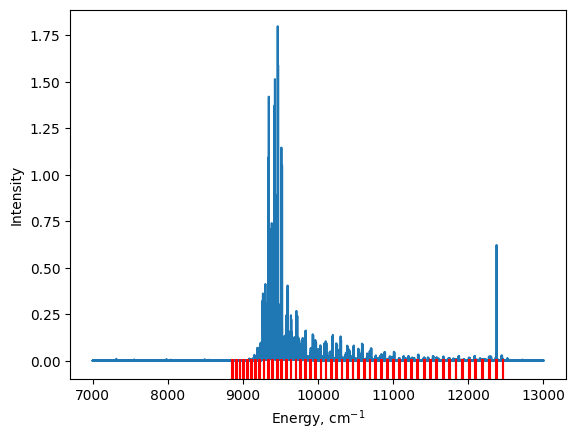

In [283]:
spectra = processor.create_spectra_instances()
currently_working_on = spectra[0]
test_spectrum = currently_working_on.create_spectrum()
test_progression = currently_working_on.find_progressions()[list(currently_working_on.find_progressions().keys())[0]]
test_progression['position']
plt.plot(test_spectrum['energy'], test_spectrum['intensity'])
# plt.xlim(9964, 9965)
plt.ylim(-0.1)
plt.vlines(test_progression['position'], ymin=-0.1, ymax=0.01, color='red')
plt.xlabel('Energy, cm$^{-1}$')
plt.ylabel('Intensity')
plt.show()

In [284]:
currently_working_on.find_nearest_intensity_testing(10291.2034)
# currently_working_on.find_nearest_intensity(10291.2034)

see if possible_intensities are correct?
             energy  intensity
218446  10291.14056        NaN
218447  10291.15563        NaN
218448  10291.17069        NaN
218449  10291.18576        NaN
218450  10291.20082     0.0034
218451  10291.21589        NaN
218452  10291.23096        NaN
218453  10291.24602        NaN
218454  10291.26109        NaN


energy       10291.20082
intensity        0.00340
Name: 218450, dtype: float64

In [285]:
currently_working_on.find_secondary_continuum()

KeyboardInterrupt: 

can we overlap the good lines (green) and ident/find lines (red)

In [199]:
test_found_lines = currently_working_on.get_progression_intensities()

taking progression 0...
taking position 0 in progression 0
Checking for max in
362853    0.00052
362854    0.00074
362855    0.00084
362856    0.00135
362857    0.00215
362858    0.00215
362859    0.00154
362860    0.00088
362861    0.00040
Name: intensity, dtype: float64
found line is 12466.867482
found line literally is:
energy       12466.86066
intensity        0.00215
Name: 362857, dtype: float64

taking position 1 in progression 0
Checking for max in
362107    0.00010
362108    0.00063
362109    0.00125
362110    0.00199
362111    0.00242
362112    0.00202
362113    0.00118
362114    0.00089
362115    0.00066
Name: intensity, dtype: float64
found line is 12455.624577
found line literally is:
energy       12455.62130
intensity        0.00242
Name: 362111, dtype: float64

taking position 2 in progression 0
Checking for max in
356799    0.00411
356800    0.00710
356801    0.01674
356802    0.03560
356803    0.08620
356804    0.22452
356805    0.52383
356806    0.62164
356807    0.281

In [262]:
test_good_lines = currently_working_on.find_good_lines_testing(test_found_lines)

taking progression 0
got point 362857 with energy energy       12466.86066
intensity        0.00215
Name: 362857, dtype: float64
continuum level around point:
0.00028484231447503157

---------------------- 1st try ---------------------
possible line is:
             energy  intensity
362853  12466.80040    0.00052
362854  12466.81546    0.00074
362855  12466.83053    0.00084
362856  12466.84559    0.00135
362857  12466.86066    0.00215
362858  12466.87573    0.00215
362859  12466.89079    0.00154
362860  12466.90586    0.00088
362861  12466.92093    0.00040
max intensity is at point:
362857
part of the line before the max index:
362853    0.00052
362854    0.00074
362855    0.00084
362856    0.00135
362857    0.00215
Name: intensity, dtype: float64
part of the line after the max index:
362857    0.00215
362858    0.00215
362859    0.00154
362860    0.00088
362861    0.00040
Name: intensity, dtype: float64
Line good before maxpoint:
True


Line good after maxpoint:
True


True
---------

In [263]:
test_good_lines

{'fin_tranJ50ajkr7568.out': [             energy  intensity
  362853  12466.80040    0.00052
  362854  12466.81546    0.00074
  362855  12466.83053    0.00084
  362856  12466.84559    0.00135
  362857  12466.86066    0.00215
  362858  12466.87573    0.00215
  362859  12466.89079    0.00154
  362860  12466.90586    0.00088
  362861  12466.92093    0.00040,
               energy  intensity
  362107  12455.56104    0.00010
  362108  12455.57610    0.00063
  362109  12455.59117    0.00125
  362110  12455.60623    0.00199
  362111  12455.62130    0.00242
  362112  12455.63637    0.00202
  362113  12455.65143    0.00118
  362114  12455.66650    0.00089
  362115  12455.68157    0.00066,
  nan,
               energy  intensity
  356056  12364.39567    0.00042
  356057  12364.41073    0.00231
  356058  12364.42580    0.00715
  356059  12364.44086    0.01325
  356060  12364.45593    0.01403
  356061  12364.47100    0.00890
  356062  12364.48606    0.00415
  356063  12364.50113    0.00190
  35606

In [207]:
old_good_lines = currently_working_on.find_good_lines(test_found_lines)
old_good_lines

taking progression 0
got point 362857 with energy energy       12466.86066
intensity        0.00215
Name: 362857, dtype: float64
continuum level around point:
0.00028484231447503157

---------------------- 1st try ---------------------
possible line is:
             energy  intensity
362853  12466.80040    0.00052
362854  12466.81546    0.00074
362855  12466.83053    0.00084
362856  12466.84559    0.00135
362857  12466.86066    0.00215
362858  12466.87573    0.00215
362859  12466.89079    0.00154
362860  12466.90586    0.00088
362861  12466.92093    0.00040
max intensity is at point:
362857
part of the line before the max index:
362853    0.00052
362854    0.00074
362855    0.00084
362856    0.00135
362857    0.00215
Name: intensity, dtype: float64
part of the line after the max index:
362857    0.00215
362858    0.00215
362859    0.00154
362860    0.00088
362861    0.00040
Name: intensity, dtype: float64
Line good before maxpoint:
True


Line good after maxpoint:
True


True
---------

{'fin_tranJ50ajkr7568.out': [             energy  intensity
  362853  12466.80040    0.00052
  362854  12466.81546    0.00074
  362855  12466.83053    0.00084
  362856  12466.84559    0.00135
  362857  12466.86066    0.00215
  362858  12466.87573    0.00215
  362859  12466.89079    0.00154
  362860  12466.90586    0.00088
  362861  12466.92093    0.00040,
               energy  intensity
  362107  12455.56104    0.00010
  362108  12455.57610    0.00063
  362109  12455.59117    0.00125
  362110  12455.60623    0.00199
  362111  12455.62130    0.00242
  362112  12455.63637    0.00202
  362113  12455.65143    0.00118
  362114  12455.66650    0.00089
  362115  12455.68157    0.00066,
  nan,
               energy  intensity
  356056  12364.39567    0.00042
  356057  12364.41073    0.00231
  356058  12364.42580    0.00715
  356059  12364.44086    0.01325
  356060  12364.45593    0.01403
  356061  12364.47100    0.00890
  356062  12364.48606    0.00415
  356063  12364.50113    0.00190
  35606